In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import GaussianBlur
import torch
from tqdm import tqdm
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=16)

In [2]:
F = pd.read_feather("/home/jeff/workspace/MIGDAL_simulator/processed/gain2000_7291F_recoils.feather")
C = pd.read_feather("/home/jeff/workspace/MIGDAL_simulator/processed/gain2000_7803C_recoils.feather")

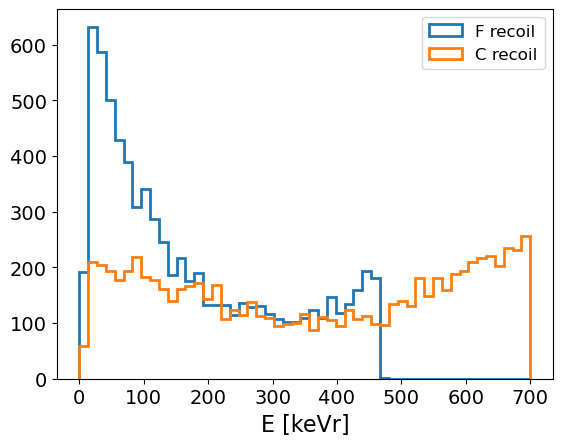

In [6]:
plt.hist(F['truthE'],bins=51,range=(0,700),label='F recoil',histtype = 'step',lw=2)
plt.hist(C['truthE'],bins=51,range=(0,700),label='C recoil', histtype = 'step',lw=2)
plt.xlabel('E [keVr]')
plt.legend()

In [7]:
gb = GaussianBlur(kernel_size = 9, sigma=(4/3,4/3))

In [74]:
%matplotlib qt
def plot(df,i,bin_size):
    tmp = df.iloc[i]
    print(tmp['truthE'])
    plt.figure(figsize=(8,4.5))
    '''Camera readout'''
    imhist = np.histogram2d(tmp['xcam'],tmp['ycam'],weights=tmp['qcam'],bins=(2048//bin_size,1152//bin_size),range=((0,2048),(0,1152)))[0].T
    #plt.imshow(np.log10(imhist+1),cmap='jet')
    out = gb(torch.tensor(imhist).unsqueeze(0)).squeeze(0).numpy()
    print(np.where(out == out.max()))
    plt.imshow(out,cmap='jet',aspect='auto')
    #plt.hist2d(tmp['xcam'],tmp['ycam'],weights=tmp['qcam'],bins=(2048,1152),range=((0,2048),(0,1152)),cmap='jet')
    plt.colorbar()
    plt.scatter(tmp['x']*2048/8/bin_size+2048/2/bin_size,tmp['y']*2048/8/bin_size+1152/2/bin_size,color='k',s=0.5)
    plt.scatter(tmp['x'][0]*2048/8/bin_size+2048/2/bin_size,tmp['y'][0]*2048/8/bin_size+1152/2/bin_size,color='white',s=120,edgecolor='k')
    highq = np.where(out == out.max())
    plt.scatter([highq[1][0]],[highq[0][0]],color='cyan',s=120,edgecolor='k')
    plt.xlim(tmp['xcam'].min()//bin_size-10,tmp['xcam'].max()//bin_size+10)
    plt.ylim(tmp['ycam'].min()//bin_size-10,tmp['ycam'].max()//bin_size+10)
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.title('%s %s keVr'%(tmp['species'],int(np.round(tmp['truthE']))))
    plt.show()

In [121]:
plot(C.query('100 < truthE < 120'),1,4)

110.329
(array([193]), array([353]))


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def plot3D(df, i, bin_size):
    tmp = df.iloc[i]

    # Extract raw data
    #xcam = tmp['xcam']
    #ycam = tmp['ycam']
    #qcam = tmp['qcam']
    
    vtxX = int(np.round(tmp['x'][0]*2048/8/bin_size+2048/2/bin_size))
    vtxY = int(np.round(tmp['y'][0]*2048/8/bin_size+1152/2/bin_size))
    heatmap = np.histogram2d(tmp['xcam'],tmp['ycam'],weights=tmp['qcam'],bins=(2048//bin_size,1152//bin_size),range=((0,2048),(0,1152)))[0].T
    out = gb(torch.tensor(heatmap).unsqueeze(0)).squeeze(0).numpy()
    sp = torch.tensor(out).to_sparse()
    ycam, xcam = sp.indices()
    qcam = sp.values()
    qvtx = out[vtxY,vtxX]
    
    print(vtxX,vtxY,qvtx)

    # Create meshgrid from raw data (no binning)
    xi = np.linspace(xcam.min(), xcam.max(), len(np.unique(xcam)))
    yi = np.linspace(ycam.min(), ycam.max(), len(np.unique(ycam)))
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate intensity values onto the grid
    zi = griddata((xcam, ycam), qcam, (xi, yi), method='linear')

    # Create a 3D figure
    fig = plt.figure(figsize=(8, 4.5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(xi, yi, zi, cmap='jet')
    ax.plot(vtxX,vtxY,qvtx,'o',markersize=10,color='w',markeredgecolor='k',zorder=1e10)

    # Add a color bar for scale
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    #ax.set_xlabel('x [pixels]')
    #ax.set_ylabel('y [pixels]')
    #ax.set_zlabel('Intensity')

    # Turn off axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')

    # Turn off ticks and tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Optionally turn off axis lines
    ax.w_xaxis.line.set_color((0, 0, 0, 0))
    ax.w_yaxis.line.set_color((0, 0, 0, 0))
    ax.w_zaxis.line.set_color((0, 0, 0, 0))


    # Title and display
    plt.title(f'{tmp["species"]} {int(np.round(tmp["truthE"]))} keVr')
    plt.show()


In [125]:
%matplotlib qt
plot3D(F.query('100 < truthE < 120'),1,bin_size=4)

260 115 2077.486465008234


/tmp/ipykernel_166775/2555006770.py:59: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((0, 0, 0, 0))
/tmp/ipykernel_166775/2555006770.py:60: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.line.set_color((0, 0, 0, 0))
/tmp/ipykernel_166775/2555006770.py:61: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_color((0, 0, 0, 0))


### Plot directional distance between pt of peak intensity and truth vertex

In [9]:
import numpy as np
import scipy.linalg  # Use scipy.linalg instead of sparse.linalg

def compute_distance_between_peak_and_vertex(df, i):
    tmp = df.iloc[i]
    xcam = np.array(tmp['xcam']).flatten()
    ycam = np.array(tmp['ycam']).flatten()
    qcam = np.array(tmp['qcam']).flatten()
    xt = np.array(tmp['x']).flatten()*2048/8+2048/2 #truth vertex
    yt = np.array(tmp['y']).flatten()*2048/8+1152/2
    data = np.vstack((xcam, ycam)).T

    # Get truth direction projected onto x-y plane
    truth_dir_xy = get_truth_direction_xy(tmp)

    # Compute principal axis and data mean
    principal_axis, data_mean, length = compute_principal_axis(data, truth_dir_xy)

    # Identify vertex and peak intensity points
    vertex_point, peak_intensity_point = find_vertex_and_peak_intensity_points(xcam, ycam, qcam, xt, yt)

    #print("Vertex point:", vertex_point)
    #print("Peak intensity point:", peak_intensity_point)

    # Project points onto principal axis
    proj_vertex = project_point_onto_axis(vertex_point, data_mean, principal_axis)
    proj_peak = project_point_onto_axis(peak_intensity_point, data_mean, principal_axis)

    #print("Projection of vertex:", proj_vertex)
    #print("Projection of peak intensity point:", proj_peak)

    # Compute distance
    scaling_factor = 80 / 2048
    distance_along_axis = (proj_vertex - proj_peak) * scaling_factor

    #print("Distance along principal axis:", distance_along_axis)

    return distance_along_axis, length

def get_truth_direction_xy(tmp):
    truth_dir = np.array(tmp['truth_dir'])

    # Project onto x-y plane
    truth_dir_xy = truth_dir[:2]

    # Avoid division by zero
    norm = np.linalg.norm(truth_dir_xy)
    if norm == 0:
        truth_dir_xy = np.array([1.0, 0.0])  # Default direction
    else:
        truth_dir_xy /= norm

    return truth_dir_xy

def compute_principal_axis(data, truth_dir_xy):
    data_mean = data.mean(axis=0)
    A = data - data_mean

    # Compute SVD
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    principal_axis = Vt[0]

    # Normalize
    principal_axis /= np.linalg.norm(principal_axis)

    # Align with truth direction
    if np.dot(principal_axis, truth_dir_xy) < 0:
        principal_axis = -principal_axis
        
    proj = (data @ Vt.T).T[0]
    length = (proj.max()-proj.min())*80/2048

    return principal_axis, data_mean, length

def find_vertex_and_peak_intensity_points(xcam, ycam, qcam, xtruth, ytruth):
    xcam = xcam.flatten()
    ycam = ycam.flatten()
    qcam = qcam.flatten()
    xtruth = xtruth.flatten()
    ytruth = ytruth.flatten()

    vertex_point = np.array([xtruth[0], ytruth[0]])

    max_intensity_index = np.argmax(qcam)
    peak_intensity_point = np.array([xcam[max_intensity_index], ycam[max_intensity_index]])

    return vertex_point, peak_intensity_point

def project_point_onto_axis(point, data_mean, principal_axis):
    point_centered = point - data_mean
    projection = np.dot(point_centered, principal_axis)
    return projection


In [11]:
distancesF = []
lengthsF = []
distancesC = []
lengthsC = []
for i in tqdm(range(0,len(F))):
    dF, lF = compute_distance_between_peak_and_vertex(F, i)
    distancesF.append(dF)
    lengthsF.append(lF)
for i in tqdm(range(0,len(C))):
    dC, lC = compute_distance_between_peak_and_vertex(C, i)
    distancesC.append(dC)
    lengthsC.append(lC)

100%|██████████████████████████████████████████████████████████| 7803/7803 [00:07<00:00, 1037.24it/s]


In [12]:
F['length'] = lengthsF
C['length'] = lengthsC
F['principal_vector_distance'] = distancesF
C['principal_vector_distance'] = distancesC

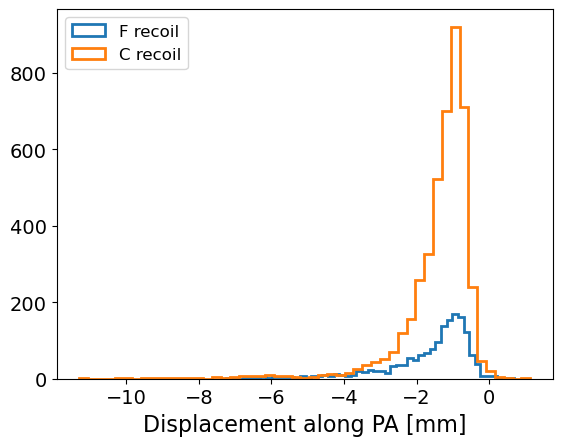

In [13]:
%matplotlib inline
plt.hist(F.query('truthE > 300')['principal_vector_distance'],bins=51,histtype='step',label='F recoil',lw=2)
plt.hist(C.query('truthE > 300')['principal_vector_distance'],bins=51,histtype='step', label='C recoil',lw=2)
#plt.yscale('log')
plt.xlabel('Displacement along PA [mm]')
plt.legend()

In [18]:
import matplotlib.pyplot as plt

def plot_PA(df, i, bin_size):
    tmp = df.iloc[i]
    xcam = tmp['xcam']//bin_size
    ycam = tmp['ycam']//bin_size
    qcam = tmp['qcam']
    xt = np.array(tmp['x']).flatten()*2048/8/bin_size+2048/2/bin_size #truth vertex
    yt = np.array(tmp['y']).flatten()*2048/8/bin_size+1152/2/bin_size
    data = np.vstack((xcam, ycam)).T

    # Get truth direction
    truth_dir_xy = get_truth_direction_xy(tmp)

    # Compute principal axis
    principal_axis, data_mean, l = compute_principal_axis(data, truth_dir_xy)

    # Identify points
    vertex_point, peak_intensity_point = find_vertex_and_peak_intensity_points(xcam, ycam, qcam, xt, yt)

    # Compute line for principal axis
    line_length = np.linalg.norm(data.max(axis=0) - data.min(axis=0)) * 1.5
    line_start = data_mean - principal_axis * line_length
    line_end = data_mean + principal_axis * line_length

    # Plotting
    plt.figure(figsize=(8, 6))
    imhist = np.histogram2d(tmp['xcam'],tmp['ycam'],weights=qcam,bins=(2048//bin_size,1152//bin_size),range=((0,2048),(0,1152)))[0].T
    out = gb(torch.tensor(imhist).unsqueeze(0)).squeeze(0).numpy()
    plt.imshow(out,aspect='auto',origin='lower',cmap='jet')
    plt.colorbar(label='Intensity')
    plt.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'r--', label='Principal Axis',lw=4)
    plt.scatter(vertex_point[0], vertex_point[1], color='white', label='Vertex', marker='o', s=100, edgecolors='k',zorder=1e10)
    plt.scatter(peak_intensity_point[0], peak_intensity_point[1], color='cyan', label='Peak Intensity', marker='o', s=100, edgecolors='k',zorder=1e10)

    # Plot truth direction vector
    # Scale the truth direction vector for visualization
    truth_dir_scaled = truth_dir_xy * line_length
    truth_line_end = data_mean + truth_dir_scaled
    plt.arrow(peak_intensity_point[0], peak_intensity_point[1], truth_dir_scaled[0]/8, truth_dir_scaled[1]/8, color='k', width=0.5, label='Truth Direction', head_width=3)

    plt.legend()
    plt.xlim(tmp['xcam'].min()//bin_size-10,tmp['xcam'].max()//bin_size+10)
    plt.ylim(tmp['ycam'].min()//bin_size-10,tmp['ycam'].max()//bin_size+10)
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.show()


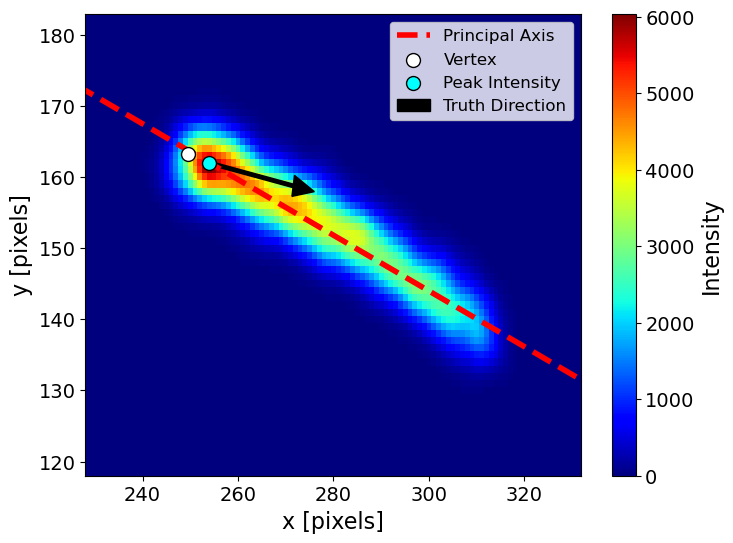

In [19]:
plot_PA(F.query('truthE > 300'),8,bin_size=4)

### Compute scalar vertex distance (Euclidean)

In [44]:
def compute_vertex_distance(df,i,bin_size=4):
    tmp = df.iloc[i]
    truth_vertex = np.array([tmp['x'][0]*2048/8/bin_size+2048/2/bin_size,tmp['y'][0]*2048/8/bin_size+1152/2/bin_size])
    #binned image
    imhist = np.histogram2d(tmp['xcam'],tmp['ycam'],weights=tmp['qcam'],bins=(2048//bin_size,1152//bin_size),range=((0,2048),(0,1152)))[0].T
    #Gaussian filtered image
    out = gb(torch.tensor(imhist).unsqueeze(0)).squeeze(0).numpy()
    crit = np.where(out == out.max())
    measured_vertex = np.array([crit[1][0],crit[0][0]])
    return np.linalg.norm(measured_vertex-truth_vertex)*80/(2048/bin_size)

In [45]:
distancesF = np.array([compute_vertex_distance(F,i,bin_size=4) for i in tqdm(range(0,len(F)))])
distancesC = np.array([compute_vertex_distance(C,i,bin_size=4) for i in tqdm(range(0,len(C)))])

100%|████████████████████████████████████████████████████████████| 7803/7803 [05:00<00:00, 25.93it/s]


In [46]:
F['vertex_distance'] = distancesF
C['vertex_distance'] = distancesC

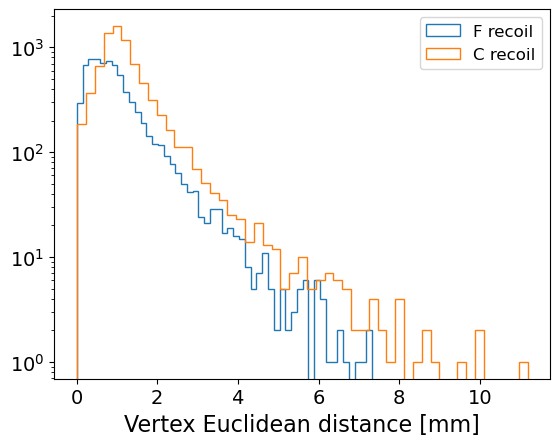

In [49]:
plt.hist(F['vertex_distance'],bins=51,histtype='step',label='F recoil')
plt.hist(C['vertex_distance'],bins=51,histtype='step', label='C recoil')
plt.yscale('log')
plt.xlabel('Vertex Euclidean distance [mm]')
plt.legend()

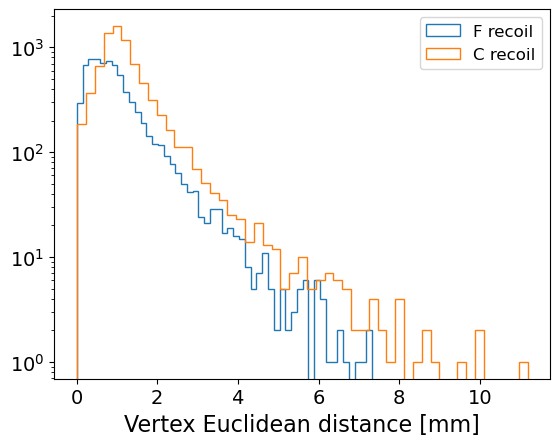

In [48]:
%matplotlib inline
plt.hist(F['vertex_distance'],bins=51,histtype='step',label='F recoil')
plt.hist(C['vertex_distance'],bins=51,histtype='step', label='C recoil')
plt.yscale('log')
plt.xlabel('Vertex Euclidean distance [mm]')
plt.legend()

In [18]:
C.query('truthE > 100')['vertex_distance'].median()

1.1451591246002448

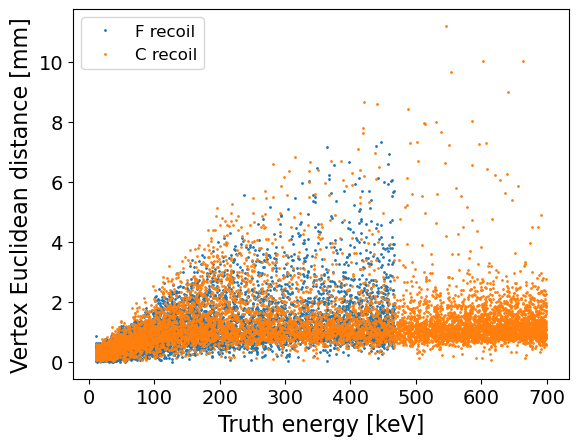

In [50]:
plt.plot(F['truthE'],F['vertex_distance'],'o',markersize = 1, label = 'F recoil')
plt.plot(C['truthE'],C['vertex_distance'],'o',markersize = 1, label = 'C recoil')

plt.xlabel('Truth energy [keV]')
plt.ylabel('Vertex Euclidean distance [mm]')
plt.legend(loc = 'upper left')

Text(0, 0.5, 'Vertex Euclidean distance [mm]')

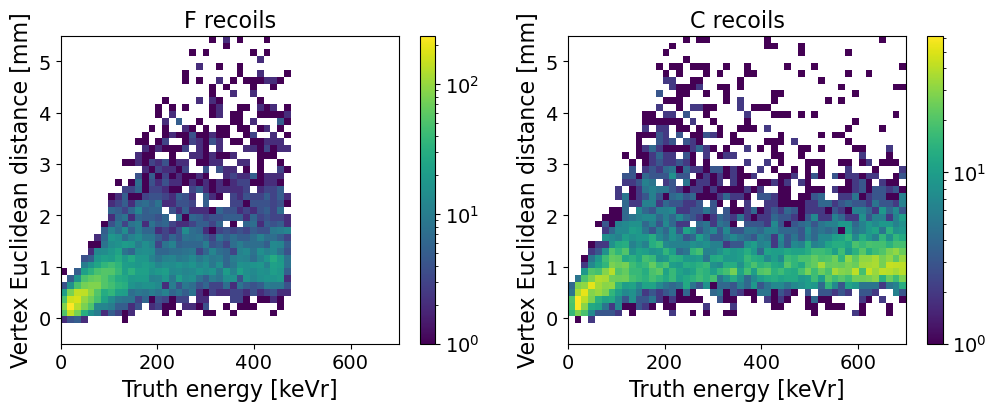

In [51]:
import matplotlib
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
co = plt.hist2d(F['truthE'],F['vertex_distance'],bins=(50,45),range=((0,700),(-0.5,5.5)),norm=matplotlib.colors.LogNorm())[3]
plt.colorbar(co)
plt.title('F recoils')
plt.xlabel('Truth energy [keVr]')
plt.ylabel('Vertex Euclidean distance [mm]')
plt.subplot(1,2,2)
co = plt.hist2d(C['truthE'],C['vertex_distance'],bins=(50,45),range=((0,700),(-0.5,5.5)),norm=matplotlib.colors.LogNorm())[3]
plt.colorbar(co)
plt.title('C recoils')
plt.xlabel('Truth energy [keVr]')
plt.ylabel('Vertex Euclidean distance [mm]')

In [177]:
F['truth_dir']

0       [0.45098155212884405, -0.8492650295430344, 0.2...
1       [0.7180102137053087, -0.6420957969829273, 0.26...
2       [-0.8637695650844218, 0.498598956319802, 0.072...
3       [0.47171618329186593, -0.813802512095329, 0.33...
4       [0.0011378386795955183, -0.4166050232398623, -...
                              ...                        
7286    [0.6929725905446498, -0.38824206861852845, 0.6...
7287    [0.7507875051382505, 0.6590149960031928, -0.04...
7288    [-0.0035935700593360607, 0.996935231465817, -0...
7289    [-0.5231207485085343, 0.8522569335993597, 0.00...
7290    [0.18105448499958107, -0.9453578330423854, 0.2...
Name: truth_dir, Length: 7291, dtype: object

### Now lets compute a directional difference

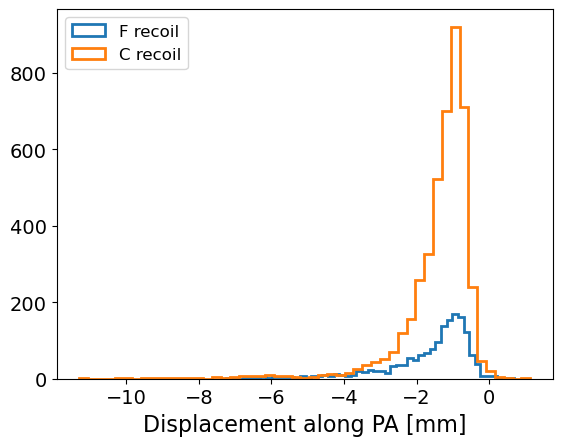

In [302]:
%matplotlib inline
plt.hist(F.query('truthE > 300')['principal_vector_distance'],bins=51,histtype='step',label='F recoil',lw=2)
plt.hist(C.query('truthE > 300')['principal_vector_distance'],bins=51,histtype='step', label='C recoil',lw=2)
#plt.yscale('log')
plt.xlabel('Displacement along PA [mm]')
plt.legend()

442.161
(array([232]), array([170]))


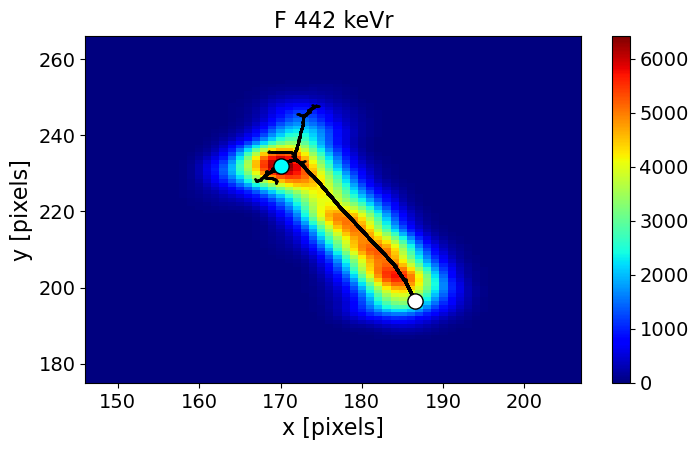

In [306]:
plot(F.query('principal_vector_distance < -6'),0,bin_size=4)

In [238]:
F[['vertex_distance','principal_vector_distance']]

,vertex_distance,principal_vector_distance
0,0.681800,-0.609235
1,1.155597,-1.251772
2,0.906845,-0.535666
3,0.448850,-0.597160
4,1.212338,-1.862310
...,...,...
7286,0.166882,-0.237065
7287,0.235300,-0.312715
7288,5.469057,-5.413120
7289,0.582858,-0.606991


375.965
(array([110]), array([202]))


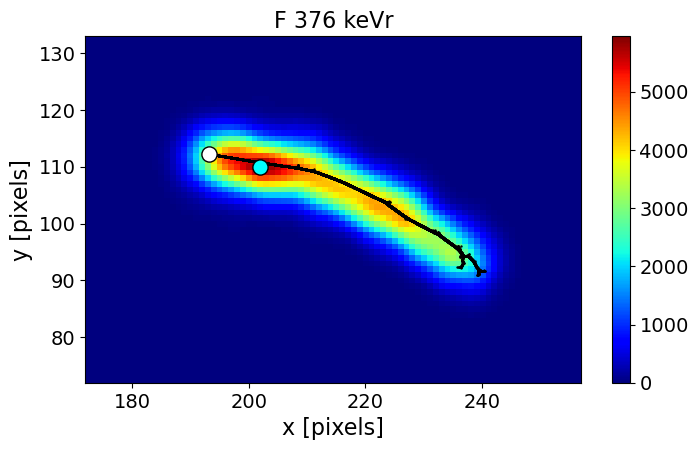

In [220]:
plot(F.query('truthE > 300'),3,bin_size = 4)

In [174]:
F['x_track'] = xtsF

In [176]:
F['x_track'].apply(lambda x: x.mean())

0      -612.936481
1       107.475185
2       214.434624
3      -533.092479
4       240.702946
           ...    
7286   -736.894796
7287   -794.504995
7288    524.535290
7289   -994.321443
7290   -460.177170
Name: x_track, Length: 7291, dtype: float64

In [55]:
F['length'] = lengthsF
C['length'] = lengthsC

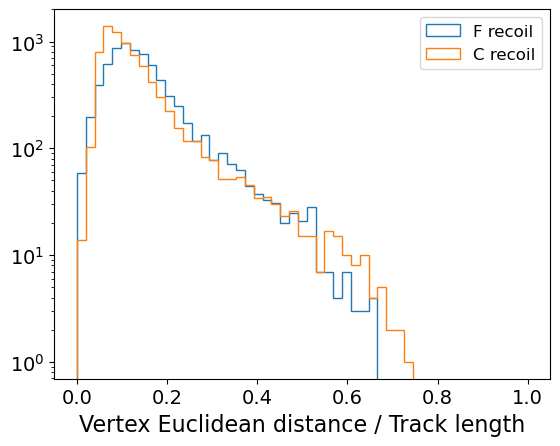

In [56]:
plt.hist(F['vertex_distance']/F['length'],bins=51,histtype='step',label='F recoil',range=(0,1))
plt.hist(C['vertex_distance']/C['length'],bins=51,histtype='step', label='C recoil',range=(0,1))
plt.yscale('log')
plt.xlabel('Vertex Euclidean distance / Track length')
plt.legend()

Text(0, 0.5, 'Vertex Euclidean distance [mm]')

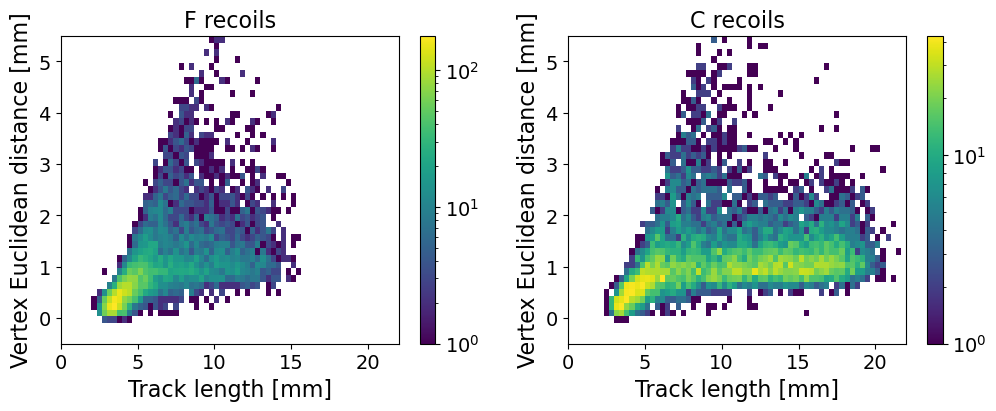

In [57]:
import matplotlib
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
co = plt.hist2d(F['length'],F['vertex_distance'],bins=(66,45),range=((0,22),(-0.5,5.5)),norm=matplotlib.colors.LogNorm())[3]
plt.colorbar(co)
plt.title('F recoils')
plt.xlabel('Track length [mm]')
plt.ylabel('Vertex Euclidean distance [mm]')
plt.subplot(1,2,2)
co = plt.hist2d(C['length'],C['vertex_distance'],bins=(66,45),range=((0,22),(-0.5,5.5)),norm=matplotlib.colors.LogNorm())[3]
plt.colorbar(co)
plt.title('C recoils')
plt.xlabel('Track length [mm]')
plt.ylabel('Vertex Euclidean distance [mm]')

In [58]:
def plot(df,i,bin_size):
    tmp = df.query('(vertex_distance / length) < 0.1 & 150 < truthE < 250').iloc[i]
    print(tmp['truthE'])
    plt.figure(figsize=(8,4.5))
    '''Camera readout'''
    imhist = np.histogram2d(tmp['xcam'],tmp['ycam'],weights=tmp['qcam'],bins=(2048//bin_size,1152//bin_size),range=((0,2048),(0,1152)))[0].T
    #plt.imshow(np.log10(imhist+1),cmap='jet')
    out = gb(torch.tensor(imhist).unsqueeze(0)).squeeze(0).numpy()
    print(np.where(out == out.max()))
    plt.imshow(out,cmap='jet',aspect='auto')
    #plt.hist2d(tmp['xcam'],tmp['ycam'],weights=tmp['qcam'],bins=(2048,1152),range=((0,2048),(0,1152)),cmap='jet')
    plt.colorbar()
    plt.scatter(tmp['x']*2048/8/bin_size+2048/2/bin_size,tmp['y']*2048/8/bin_size+1152/2/bin_size,color='k',s=0.5)
    plt.scatter(tmp['x'][0]*2048/8/bin_size+2048/2/bin_size,tmp['y'][0]*2048/8/bin_size+1152/2/bin_size,color='white',s=120,edgecolor='k')
    highq = np.where(out == out.max())
    plt.scatter([highq[1][0]],[highq[0][0]],color='cyan',s=120,edgecolor='k')
    plt.xlim(tmp['xcam'].min()//bin_size-10,tmp['xcam'].max()//bin_size+10)
    plt.ylim(tmp['ycam'].min()//bin_size-10,tmp['ycam'].max()//bin_size+10)
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.title('%s %s keVr'%(tmp['species'],int(np.round(tmp['truthE']))))
    plt.show()

232.072
(array([166]), array([218]))


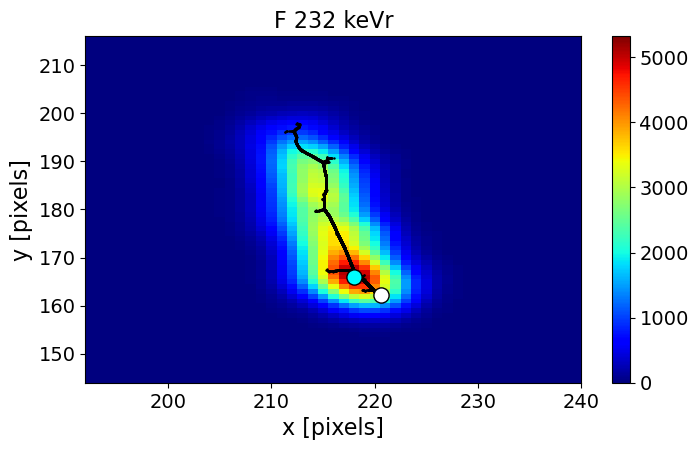

In [59]:
plot(F,11,bin_size=4)

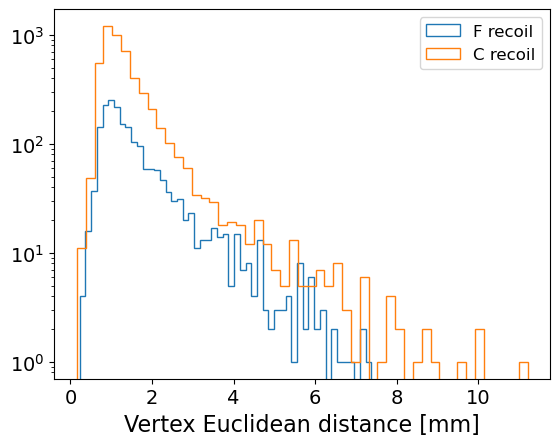

In [140]:
plt.hist(F.query('length > 8')['vertex_distance'],bins=51,histtype='step',label='F recoil')
plt.hist(C.query('length > 8')['vertex_distance'],bins=51,histtype='step', label='C recoil')
plt.yscale('log')
plt.xlabel('Vertex Euclidean distance [mm]')
plt.legend()

In [148]:
np.quantile(C.query('length > 8')['vertex_distance'],0.9)

2.335844374262097